<a href="https://colab.research.google.com/github/MR1319/SYMANTECS/blob/main/SyMANTIC_vs_PySINDy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Installation***

In [1]:
!pip install symantic
!pip install pysindy
!pip uninstall importlib-metadata
!pip install importlib-metadata==7.1.0


Found existing installation: importlib_metadata 7.2.1
Uninstalling importlib_metadata-7.2.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/importlib_metadata-7.2.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/importlib_metadata/*
Proceed (Y/n)? Y
  Successfully uninstalled importlib_metadata-7.2.1


# ***Example Setup***

(x)' = -10.000 x + 10.000 y
(y)' = -3.265 1 + 6.591 x + 11.441 y + -0.599 y z
(z)' = -2.667 z + 1.000 x y
Performing MultiTask Symbolic regression!!..
Performing symbolic regression of 1 Target variables....
************************************************ Starting Feature Space Construction in cpu ************************************************ 



************************************************ Implementing Automatic Expansion and construction of sparse models..!!! ************************************************ 

************************************************ Initial Feature Expansion Completed with feature space size::: 6 ************************************************ 

************************************************ Time taken to create the space is::: 0.1221470832824707  Seconds... ************************************************ 

************************************************ Given Number of features in SIS screening is greater than the feature space created, changing

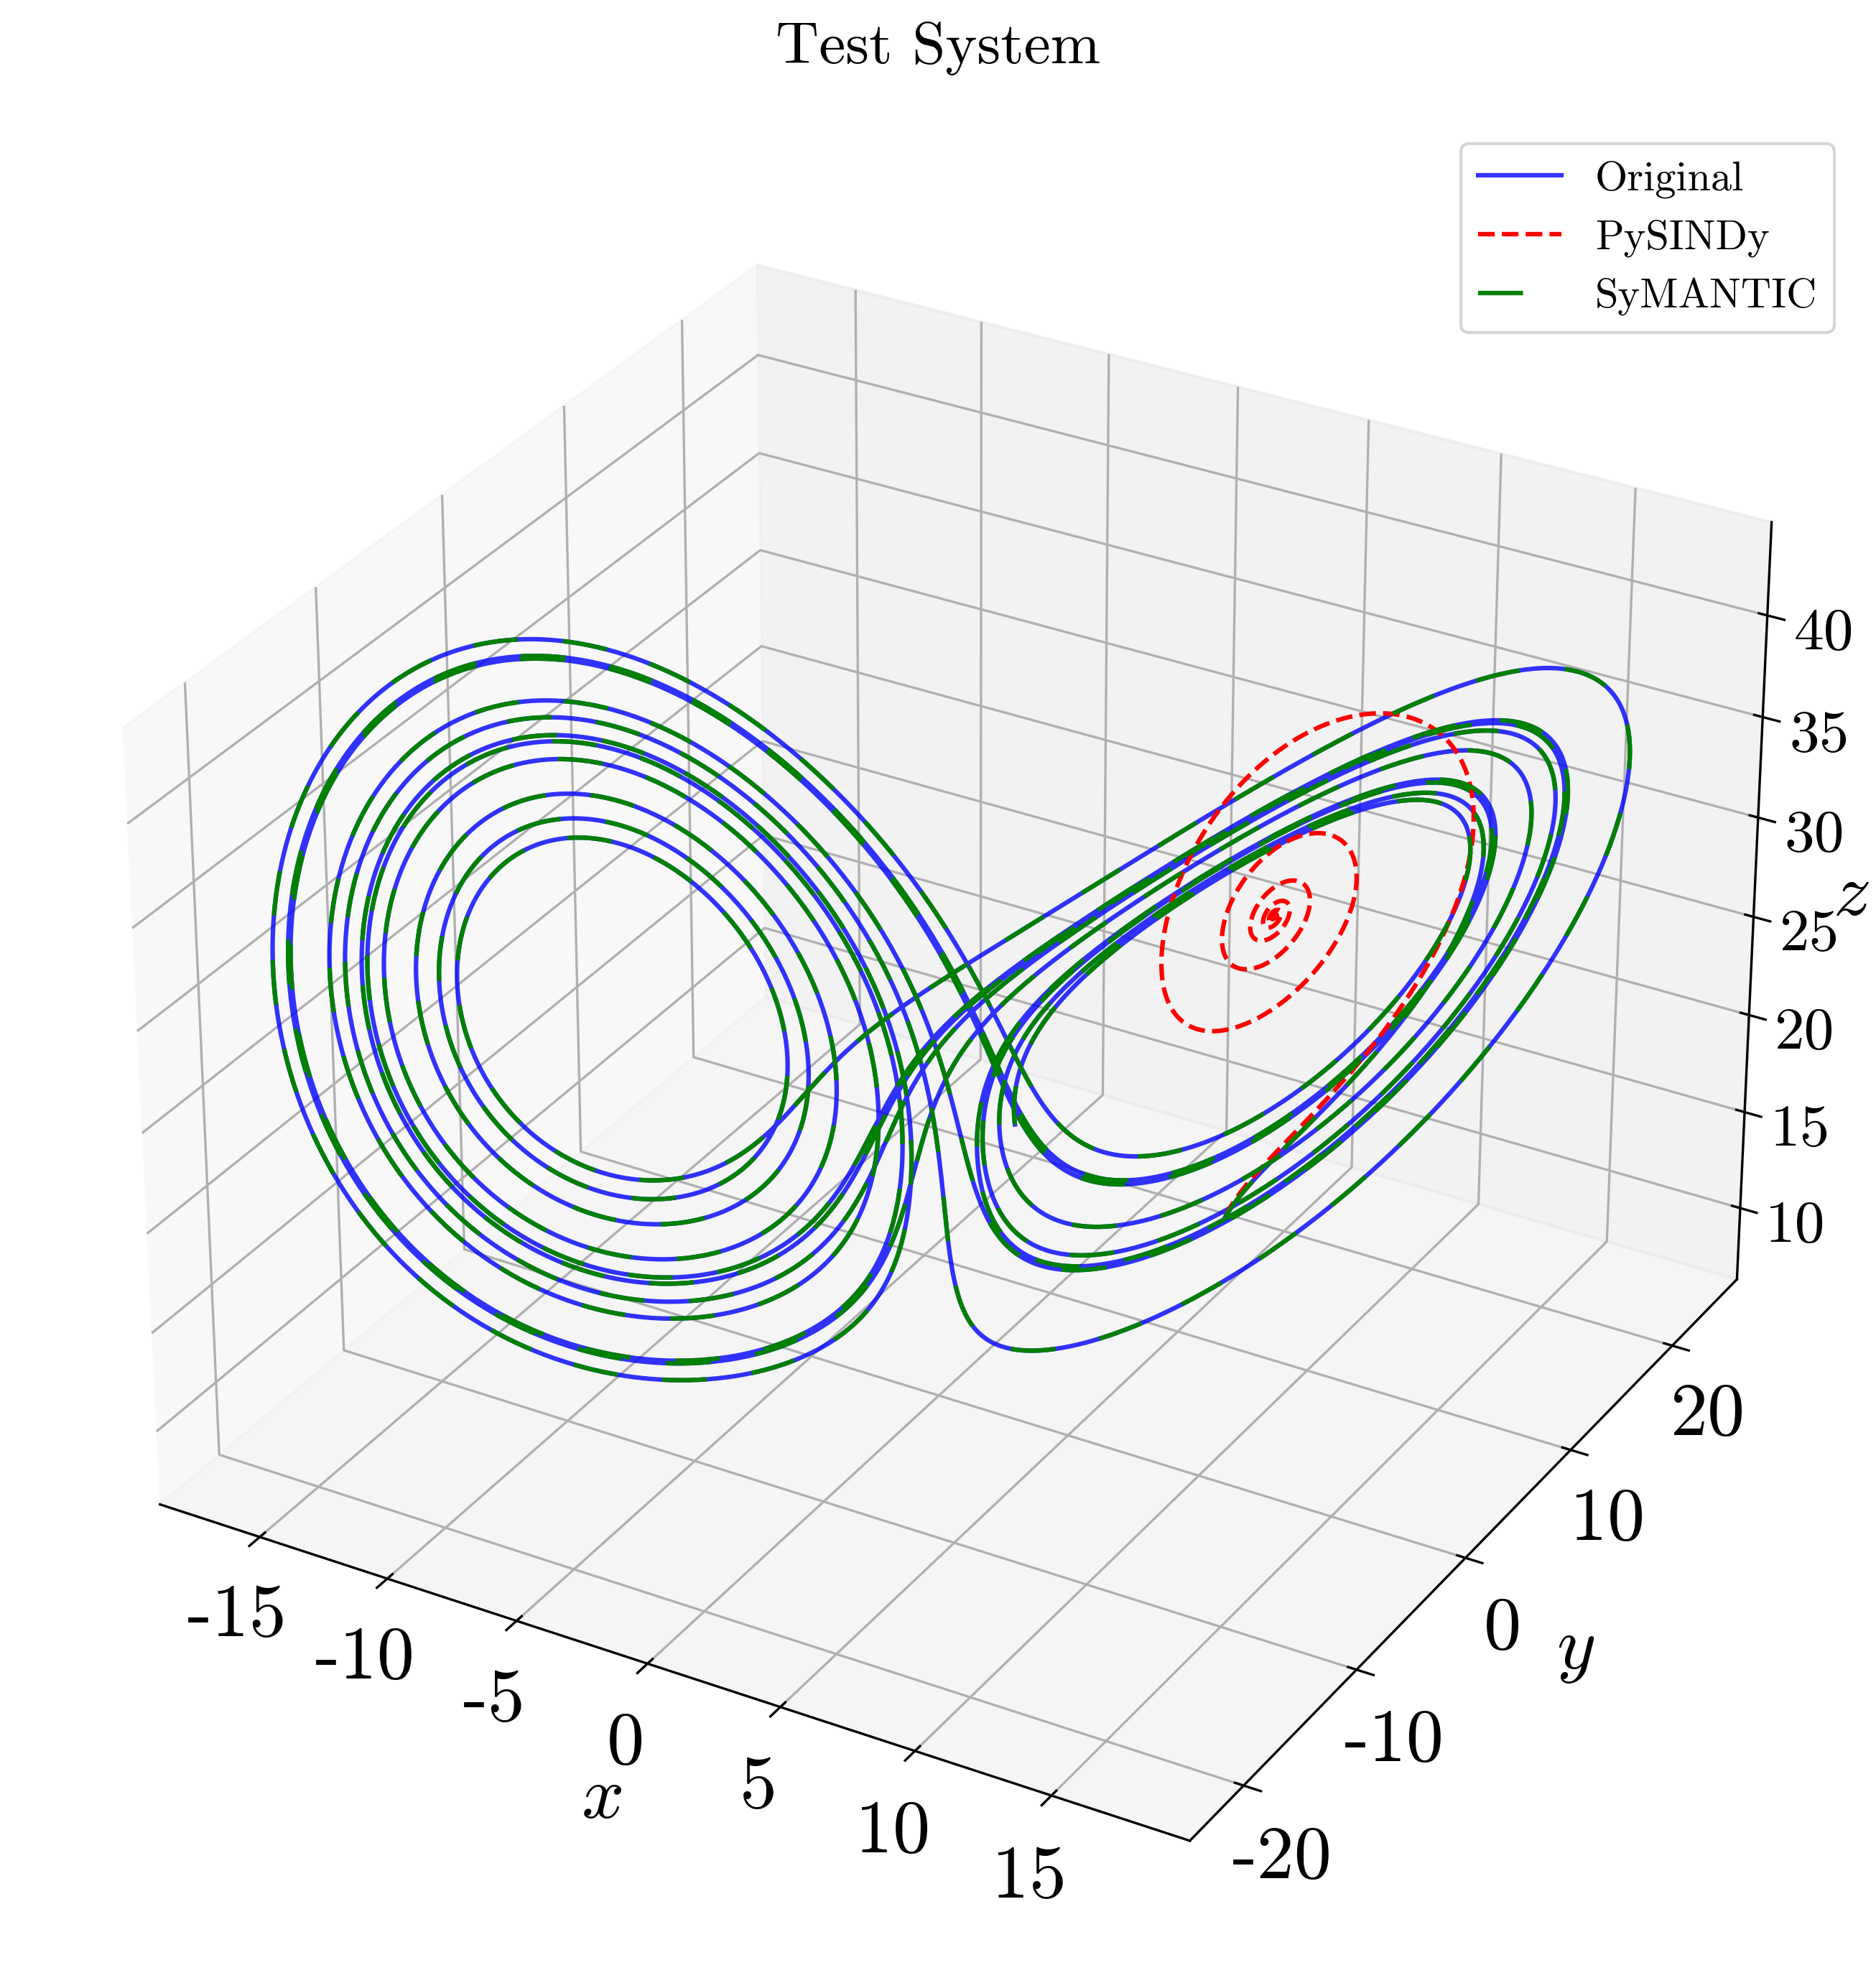

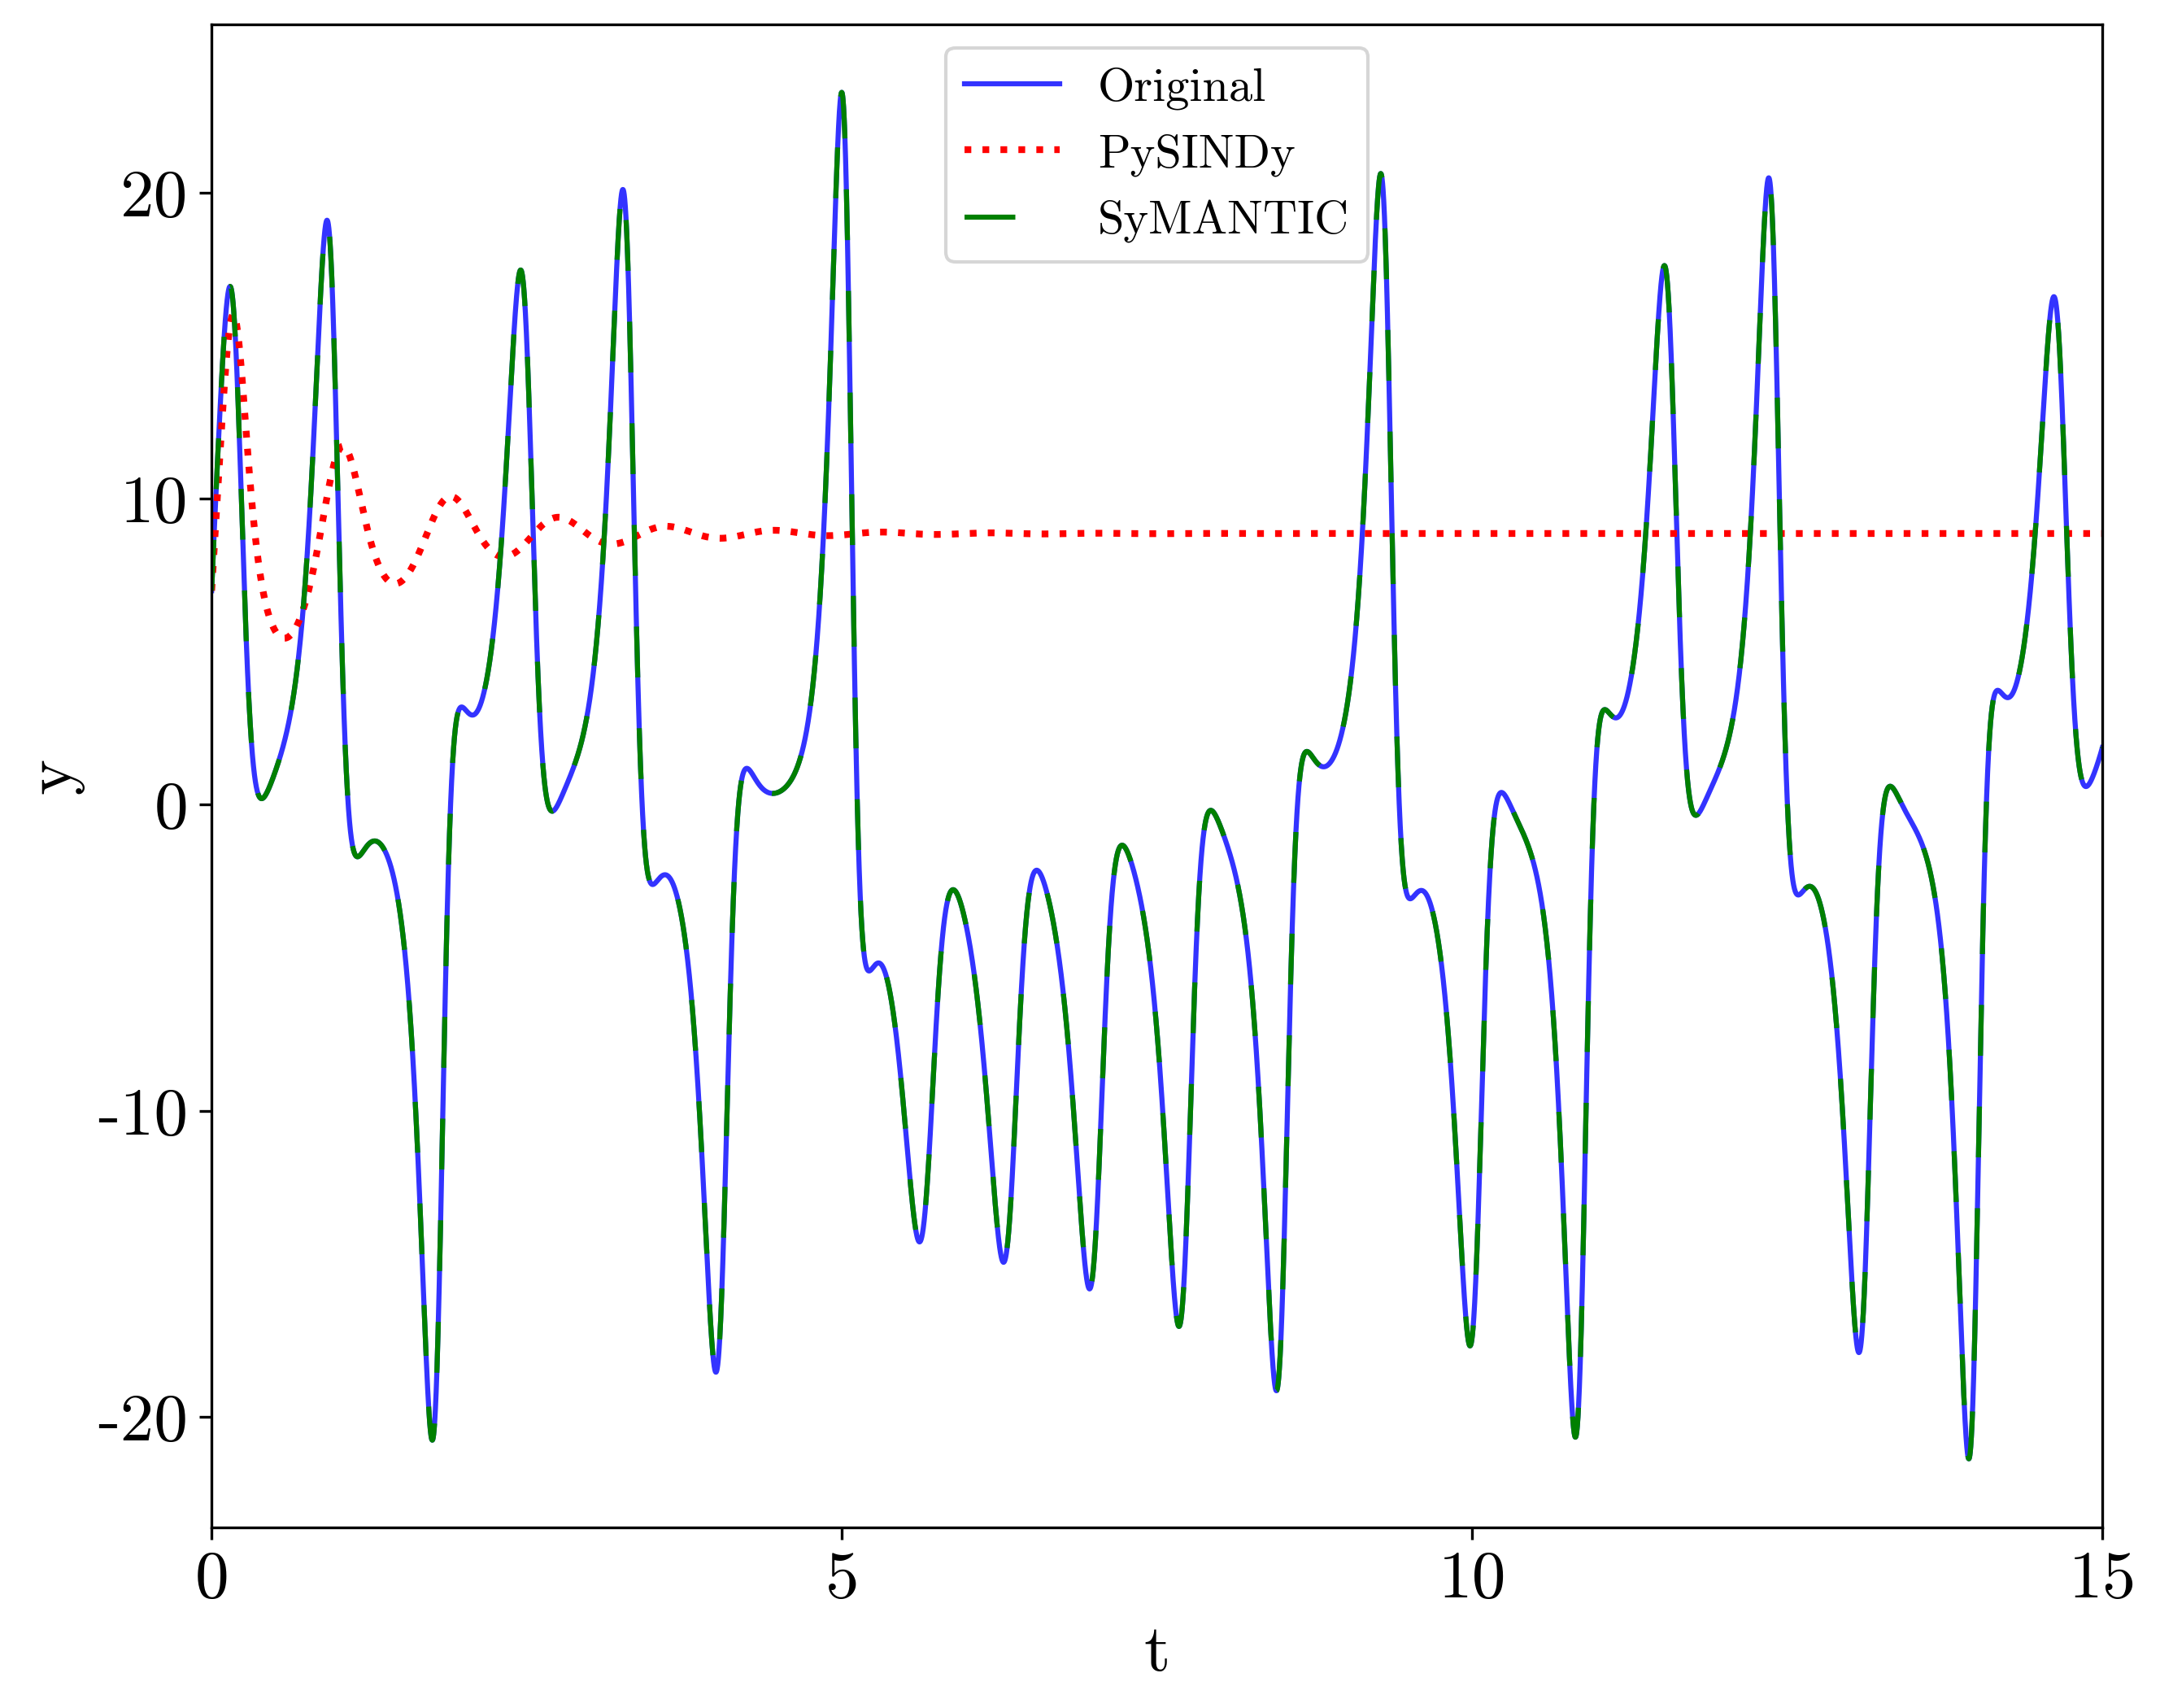

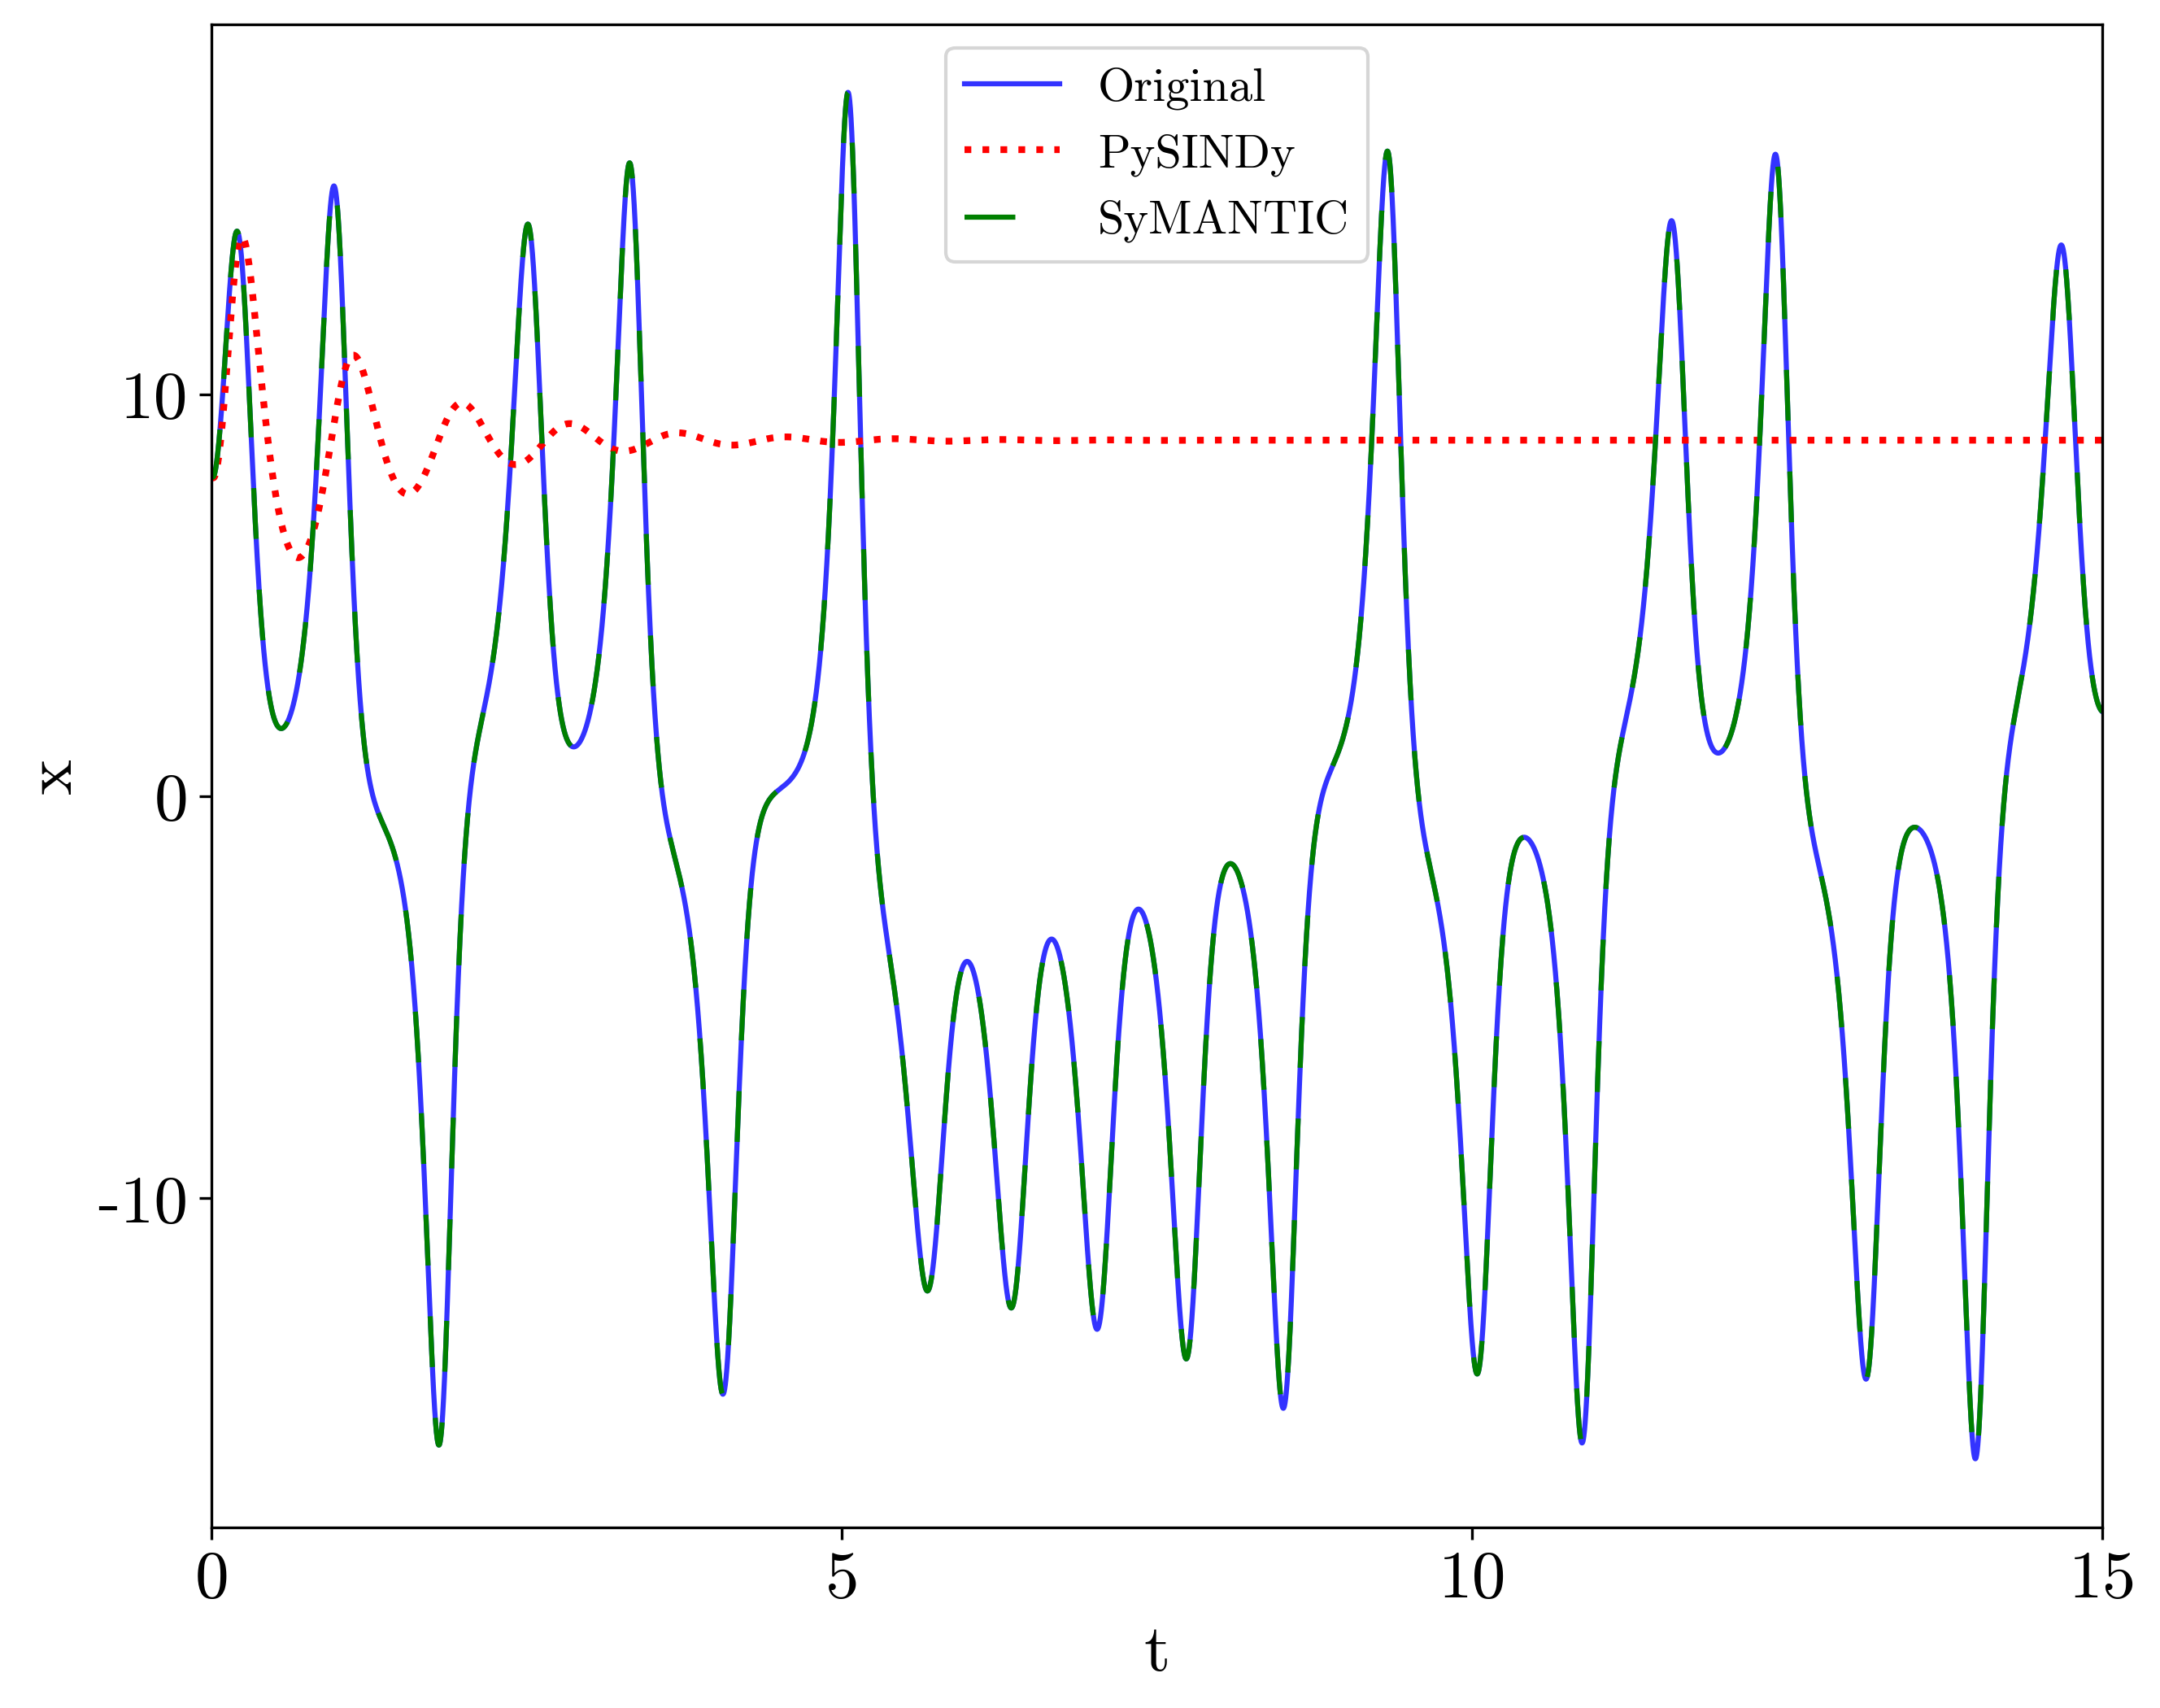

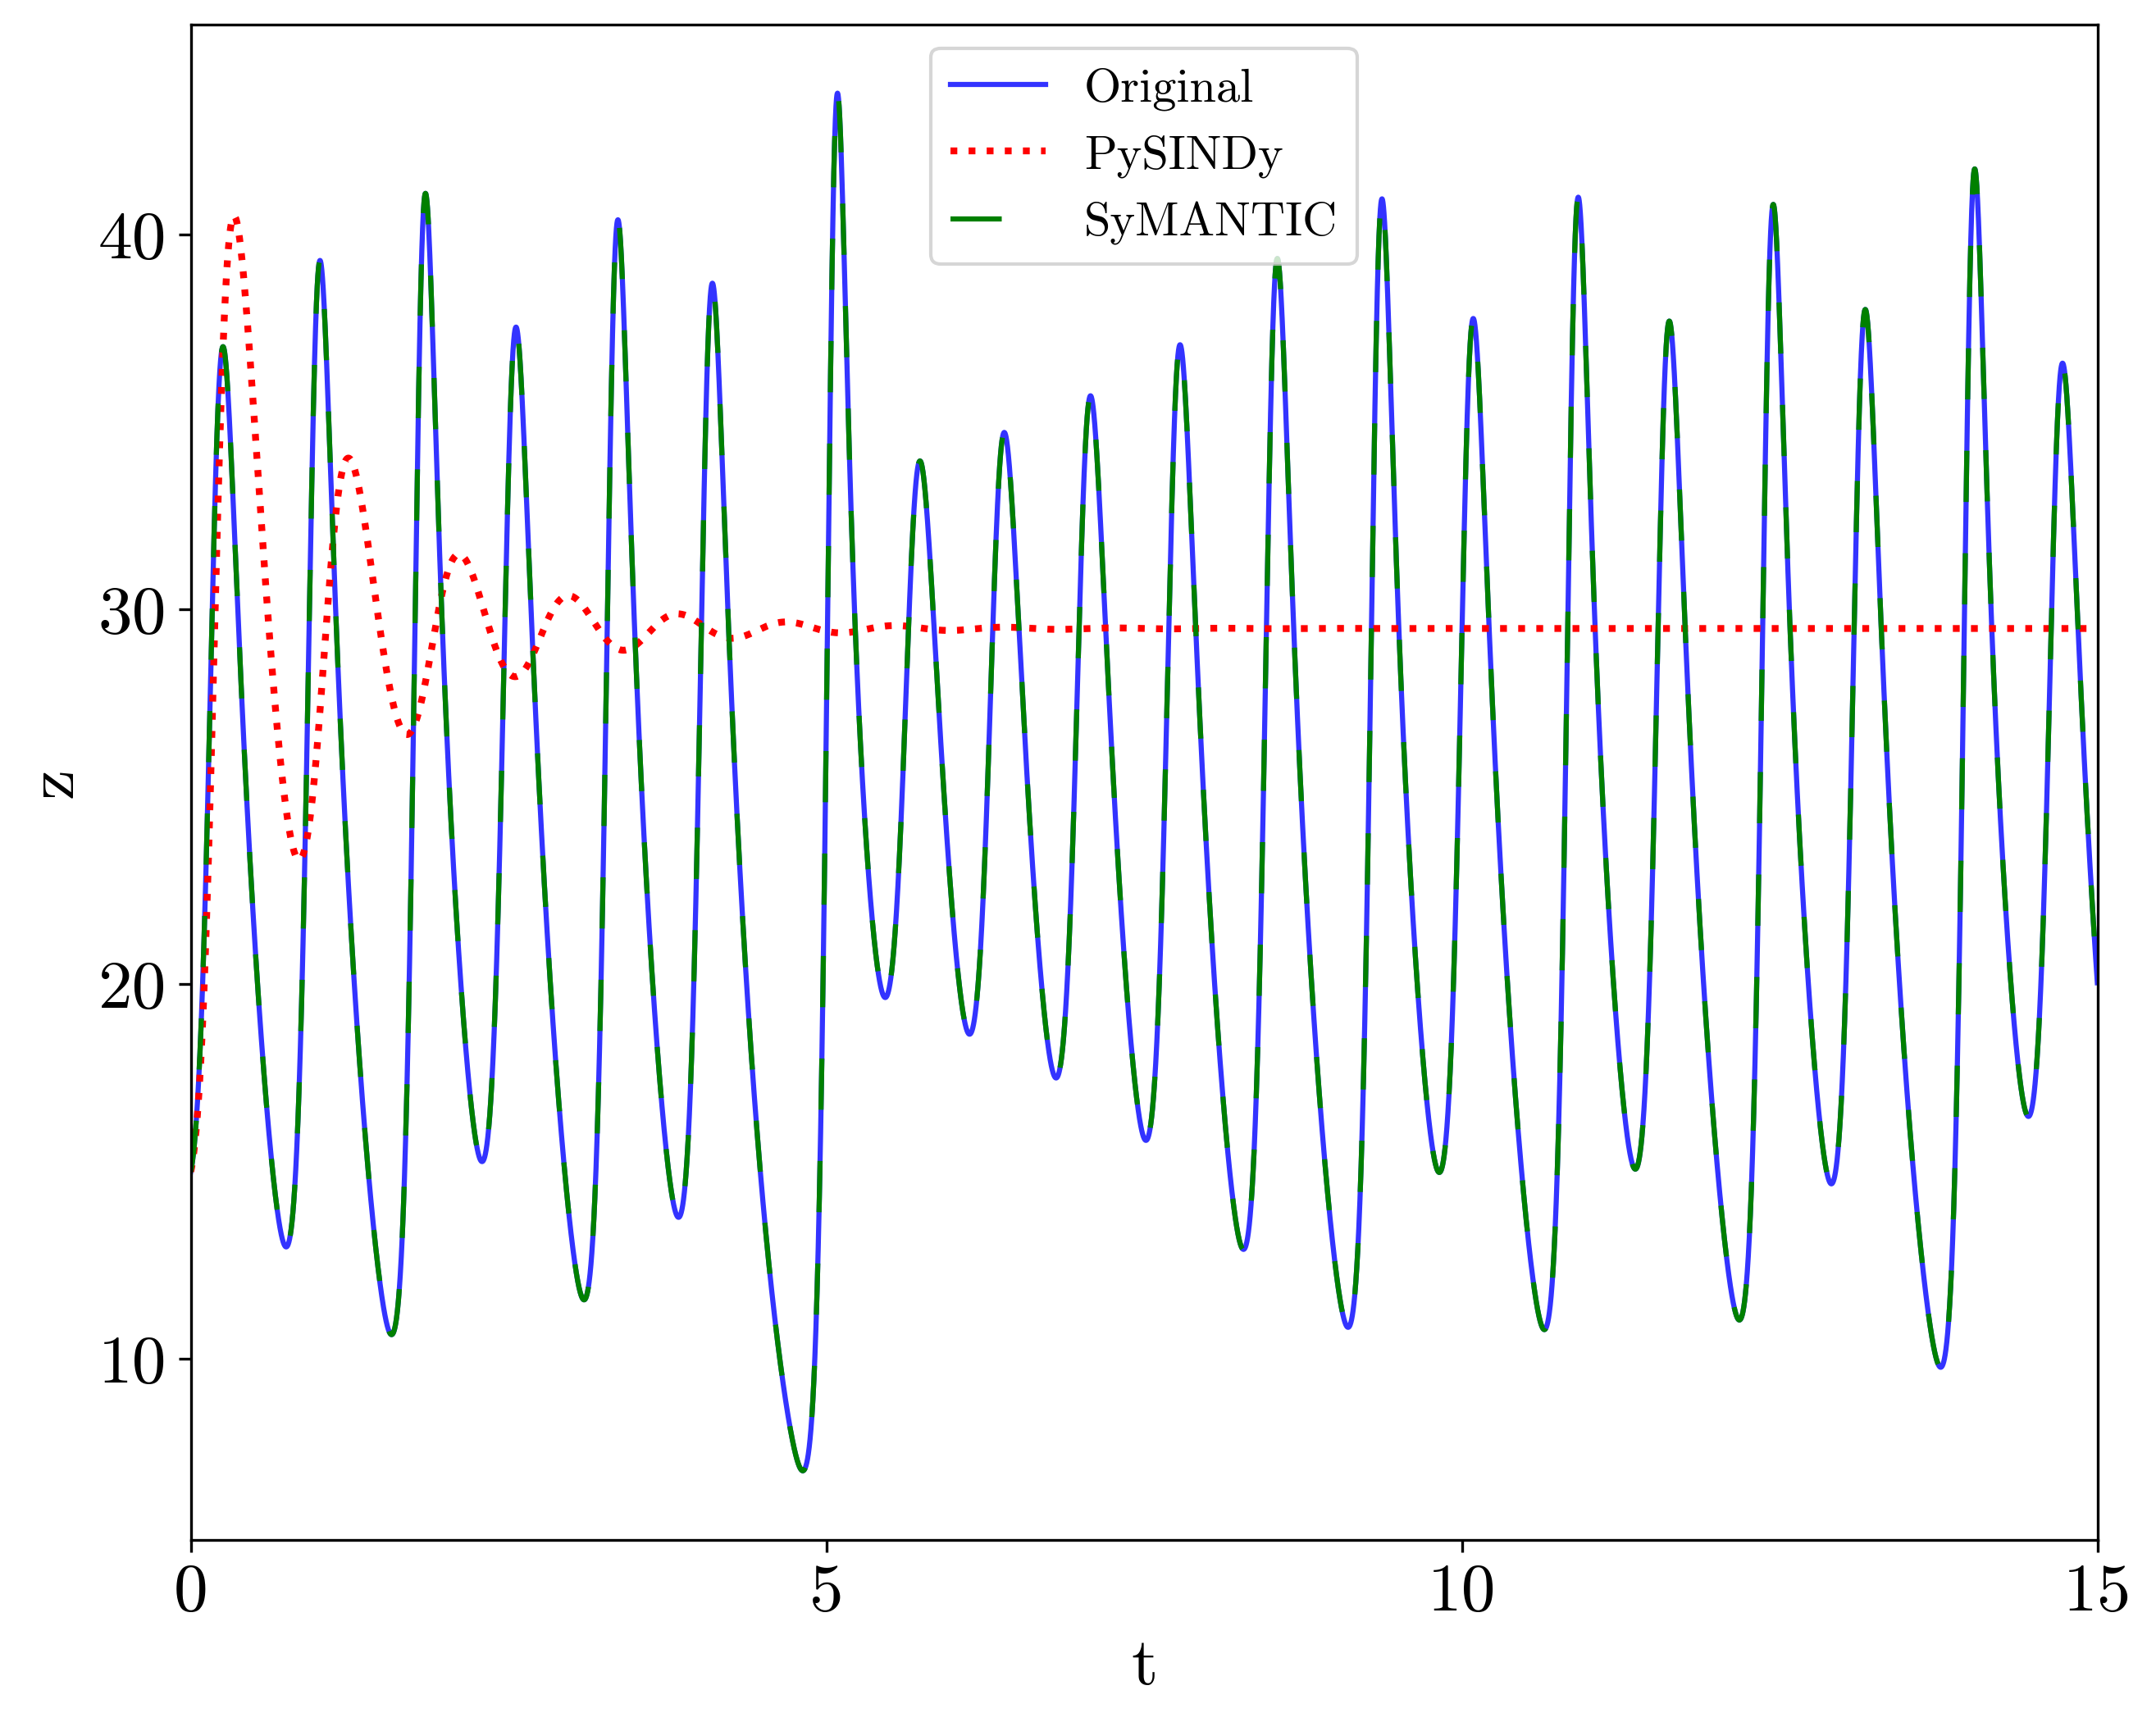

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from symantic import symantic_model

#from pysindy import utils# import linear_damped_SHO
from pysindy.utils import cubic_damped_SHO
from pysindy.utils import linear_3D
from pysindy.utils import hopf
from pysindy.utils import lorenz
import pandas as pd
import pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

dt = 0.001
t_train = np.arange(0, 100, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T
x_dot_train_measured = np.array(
    [lorenz(0, x_train[i]) for i in range(t_train.size)]
)


y1 = x_dot_train_measured[:,0]
y2 = x_dot_train_measured[:,1]
y3 = x_dot_train_measured[:,2]

cols = ['x','y','z']

df = pd.DataFrame(x_train,columns=cols)
df.insert(0,'Target1',y1)
df.insert(1,'Target2',y2)
df.insert(2,'Target3',y3)
df['Time'] = t_train

import random
random.seed(41)
random_numbers = sorted(random.sample(range(1, 100000), 5))


df1 = df.iloc[random_numbers,:]
df.drop(df1.index,inplace=True)
df1.reset_index(drop=True,inplace=True)

model = ps.SINDy(feature_library=ps.PolynomialLibrary(interaction_only=True),feature_names=['x','y','z'])
model.fit(df1.iloc[:,[3,4,5]].to_numpy(),t = df1.Time.to_numpy(),x_dot=df1.iloc[:,[0,1,2]].to_numpy())
model.print()


operators = ['*']
rmse,equation,r2,equations = symantic_model(df1.iloc[:,:-1],operators=operators,multi_task=[[0,1,2],[[3,4,5],[3,4,5],[3,4,5]]],metrics=[0.05,0.99]).fit()




x = df.iloc[:,3]
y = df.iloc[:,4]
z = df.iloc[:,5]



t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
t_test_span = (t_test[0], t_test[-1])
x_test = solve_ivp(
    lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T


x_test1 = model.simulate(x0_test, t_test)

def lorenz_2(t,x):
    return [
        10.0000*(x[1]-x[0]),
        -1.000*x[0]*x[2] -1.000000*x[1]   + 28.000000*x[0],
         1.0000000*x[0]*x[1] -2.666670000000000*x[2]
    ]


x_test2= solve_ivp(
    lorenz_2, t_test_span, x0_test, t_eval=t_test, **integrator_keywords
).y.T




import matplotlib
matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            'figure.dpi' : 300,

                            })

font = {'weight' : 'bold',
        'size'   : 34}
plt.rc('font', **font)



fig = plt.figure(figsize=(10, 10))
ax1 = plt.axes(projection="3d")
ax1.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], color='blue', label='Original', alpha=0.8, lw=1.5, linestyle='-')
ax1.plot(x_test1[:,0],x_test1[:,1],x_test1[:,2], "k",color='red',label=f'PySINDy',alpha=1.0,linestyle='--',lw = 1.5)
line2, = ax1.plot(x_test2[:, 0], x_test2[:, 1], x_test2[:, 2], color='green', label='SyMANTIC', alpha=1.0, lw=1.5, linestyle='--')

line2.set_dashes([10, 10])

ax1.set_xlabel("$x$", fontsize=25, labelpad=10, weight='bold')
ax1.set_ylabel("$y$", fontsize=25, labelpad=10, weight='bold')
ax1.set_zlabel("$z$", fontsize=25, weight='bold')
ax1.zaxis.labelpad = -1.0
ax1.tick_params(axis='x', labelsize=25)
ax1.tick_params(axis='y', labelsize=25)
ax1.tick_params(axis='z', labelsize=20)
ax1.set_title("Test System", fontsize=20, pad=20, weight='bold')

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()




plt.figure(figsize=(10,8))
plt.plot(t_test[:], x_test[:,1], label='Original', alpha=0.8, c='blue', linewidth=1.5,linestyle='-')
plt.plot(t_test, x_test1[:,1], label='PySINDy', alpha=1.0, c='red', linewidth=2,linestyle='dotted')
line2, = plt.plot(t_test[:], x_test2[:,1], label='SyMANTIC', alpha=1.0, c='green', linewidth=1.5,linestyle='--')
line2.set_dashes([10, 10])

plt.xlabel('t',weight='bold',fontsize=20)
plt.ylabel('y',weight='bold',fontsize=20)
plt.xlim(0,15)
plt.legend(fontsize=14)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()




plt.figure(figsize=(10,8))
plt.plot(t_test[:], x_test[:,0], label='Original', alpha=0.8, c='blue', linewidth=1.5,linestyle='-')
plt.plot(t_test, x_test1[:,0], label='PySINDy', alpha=1.0, c='red', linewidth=2,linestyle='dotted')
line2, = plt.plot(t_test[:], x_test2[:,0], label='SyMANTIC', alpha=1.0, c='green', linewidth=1.5,linestyle='--')
line2.set_dashes([10, 10])

plt.xlabel('t',weight='bold',fontsize=20)
plt.ylabel('x',weight='bold',fontsize=20)
plt.xlim(0,15)
plt.legend(fontsize=14)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()



plt.figure(figsize=(10,8))
plt.plot(t_test[:], x_test[:,2], label='Original', alpha=0.8, c='blue', linewidth=1.5,linestyle='-')
plt.plot(t_test, x_test1[:,2], label='PySINDy', alpha=1.0, c='red', linewidth=2,linestyle='dotted')
line2, = plt.plot(t_test[:], x_test2[:,2], label='SyMANTIC', alpha=1.0, c='green', linewidth=1.5,linestyle='--')
line2.set_dashes([10, 10])

plt.xlabel('t',weight='bold',fontsize=20)
plt.ylabel('z',weight='bold',fontsize=20)
plt.xlim(0,15)
plt.legend(fontsize=14)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()





